# Solar Power Generation Data - Semester project in TK8117

This project considers data from two solar powerplants, collected over a 34-day period. For the sake of this exercise the two powerplants are named Powerplant **Alpha** and Powerplant **Charlie**. For the solar powerplants there are several areas of concern:

* Can we predict the power generation for next couple of days?
* Can we predict the power generation of a plant, based on environmental sensor measurements in and around the plant?
* Can we identify the need for panel cleaning/maintenance?
* Can we identify faulty or suboptimally performing equipment?



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from pandas.plotting import scatter_matrix
from math import sqrt


base_time = pd.Timestamp('2020-05-15')

\
## Import and first look at the Generator Data

The data for each powerplant is split into two tables. We will begin by looking at the two files from powerplant **Alpha**. The two tables are:

* ```Plant_Alpha_Generation_Data.csv ``` Containing data about the power generation of the powerplant sampled at 15-minute intervals


* ```Plant_Alpha_Weather_Sensor_Data.csv ``` Containing data about the weather conditions at the plant, as well as some sensor data from some intrinsic sensors in the powerplant 

Lets first have a look at the generation data from powerplant **Alpha**:


In [2]:
alpha_generator_data_path = 'dataset/Plant_Alpha_Generation_Data.csv'
alpha_generator_data = pd.read_csv(alpha_generator_data_path, parse_dates=["DATE_TIME"])

alpha_generator_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [3]:
alpha_generator_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.7+ MB


The remaining columns in the generator data can ble explained as such:

* ```DATE_TIME``` Shows the time and date of the measurement. The measurements from the powerplant are done at intervals of 15 minutes *Note that the date and time are not unique for each row. There are multiple measurements every 15 minute interval, for each unique inverter in the powerplant*
* ```PLANT_ID``` Refers is a unique identifier for plant **Alpha** and remains the same throughout the dataset. 
* ```SOURCE_KEY``` Is a unique identifier for each inverter in the powerplant
* ```DC_POWER``` Is the DC power produced by a single inverter at the given timestamp in kW
* ```AC_POWER``` Is the AC power produced by a single inverter at the given timestamp in kW
* ```DAILY_YIELD``` Is a cumulative measure of the power produced by a single inverter throughout the day. The daily yield resets to zero at midnight

* ```TOTAL_YIELD``` Gives the total yield for the inverter till that point in time.




When looking at the first few columns of data, we see that the ```DC_POWER```, ```AC_POWER``` and ```DAILY_YIELD``` fields are zero, which intuitively makes sense, as the data recording starts at midnight May 15th when the sun has set and the powerplant does not produce any power.

Lets look at some more interesting data from around 11:30 later on the same day:

In [4]:
alpha_generator_data[990:1020]

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
990,2020-05-15 11:15:00,4135001,zBIq5rxdHJRwDNY,8240.000000,805.550000,2271.375000,6341651.375
991,2020-05-15 11:15:00,4135001,zVJPv84UY57bAof,8617.500000,842.275000,1922.250000,7118073.250
992,2020-05-15 11:30:00,4135001,1BY6WEcLGh8j5v7,6226.125000,609.862500,1994.500000,6261553.500
993,2020-05-15 11:30:00,4135001,1IF53ai7Xc0U56Y,7405.285714,724.442857,2377.571429,6186022.571
994,2020-05-15 11:30:00,4135001,3PZuoBAID5Wc2HD,8226.857143,803.671429,2295.857143,6990054.857
995,2020-05-15 11:30:00,4135001,7JYdWkrLSPkdwr4,7328.000000,716.928571,2242.000000,7605202.000
996,2020-05-15 11:30:00,4135001,McdE0feGgRqW7Ca,6471.285714,633.857143,2518.714286,7161482.714
997,2020-05-15 11:30:00,4135001,VHMLBKoKgIrUVDU,7761.142857,759.214286,2252.285714,7208660.286
998,2020-05-15 11:30:00,4135001,WRmjgnKYAwPKWDb,8600.571429,840.085714,2217.000000,7030890.000
999,2020-05-15 11:30:00,4135001,YxYtjZvoooNbGkE,6340.500000,621.012500,2394.875000,7182360.875


\
## Import and first look at the Sensor Data

We will now have a look at some of the associated weather sensor data from powerplant **Alpha**:

In [5]:
alpha_sensor_data_path = 'dataset/Plant_Alpha_Weather_Sensor_Data.csv'
alpha_sensor_data = pd.read_csv(alpha_sensor_data_path, parse_dates=["DATE_TIME"])

alpha_sensor_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [6]:
alpha_sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 149.3+ KB


The data is structured quite similarly to the generator data. The collumns can be explained as such:

* ```DATE_TIME``` Shows the time and date of the measurement. The measurements from the powerplant are done at intervals of 15 minutes
* ```PLANT_ID``` Refers is a unique identifier for plant **Alpha** and remains the same throughout the dataset. 
* ```SOURCE_KEY``` Is a unique identifier for each sensor array in the plant. *Note: There is only one sensor array in Powerplant **Alpha**, which means that ```SOURCE_KEY``` remains constant throughout the dataset*
* ```AMBIENT_TEMPERATURE``` The measured ambient outdoors temperature at the powerplant in Degrees Celsius
* ```MODULE_TEMPERATURE``` There's a solar panel attached to the sensor array. This is the temperature reading for that solar panel in Degrees Celsius
* ```IRRADIATION``` Amount of irradiation from the sun for the 15 minute interval.


\
## Merging of data tables and data imputation

In order to produce a single dataset which we can do some further analysis on, we want to merge these two tables into a single table, where each row represents a single generator measurement taken at an arbitrary time showing features such as DC Power and AC Power paired with the sensor measurements such as Irradiation and Temperature taken at the same time.

We merge the data with the key being the field ```DATE_TIME``` which is present in both the generator data and sensor data from powerplant **Alpha**. In practice, this means that every measurement from the generator data is paired with a sensor measurement from the sensor data *with the same timestamp*

In [7]:
alpha_sensor_data = alpha_sensor_data.rename(columns={"SOURCE_KEY":"SOURCE_KEY_SENSOR"}).drop(columns=["PLANT_ID"])
alpha_generator_data = alpha_generator_data.rename(columns={"SOURCE_KEY":"SOURCE_KEY_INVERTER"})

In [8]:
alpha_data = pd.merge(alpha_sensor_data, alpha_generator_data, on="DATE_TIME")
alpha_data.head()

,DATE_TIME,SOURCE_KEY_SENSOR,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,SOURCE_KEY_INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [9]:
alpha_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45680 entries, 0 to 45679
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            45680 non-null  datetime64[ns]
 1   SOURCE_KEY_SENSOR    45680 non-null  object        
 2   AMBIENT_TEMPERATURE  45680 non-null  float64       
 3   MODULE_TEMPERATURE   45680 non-null  float64       
 4   IRRADIATION          45680 non-null  float64       
 5   PLANT_ID             45680 non-null  int64         
 6   SOURCE_KEY_INVERTER  45680 non-null  object        
 7   DC_POWER             45680 non-null  float64       
 8   AC_POWER             45680 non-null  float64       
 9   DAILY_YIELD          45680 non-null  float64       
 10  TOTAL_YIELD          45680 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 4.2+ MB


Here we can spot an interesting phenomenon. The length of the merged data table seems to be different from the data tables we put into the merge. Intuitively, the resulting data table should have the same length as generator data table, as each row of the generator data table was paired with a sensor measurement. However, there is a difference of:

In [10]:
len(alpha_data.index) - len(alpha_generator_data.index)

-23098

rows. We consult with the creator of the dataset who states

> (...) That happens because of various reasons - e.g. sometimes an inverter or two goes down, sometimes they are deliberately taken down for maintenance or taken offline to avoid power surges on the grid (this is done as per instructions from the local power grid management authorities)

There is some missing data from both the sensor data table and the generator data table, which causes the discrepancy. Due to the size and simplicity of the dataset we choose to simply leave out the data rows where it wasn't possible to match the data from the generation data table and the sensor data table. In the case that only a few scattered fields were missing, it might have been possible to peroform some kind og data imputation, but as the missing data from this dataset spans hours, if not days, it is seen as more reasonable to leave the incomplete data out of the analysis

\
## A First look at the merged data

We begin by pulling out the data from a single inverter, and study how it develops in time. We arbitrarily pick the inverter labeled ```1BY6WEcLGh8j5v7``` and see how its AC power output evolves over time:

In [11]:
single_inverter_data = alpha_data[alpha_data["SOURCE_KEY_INVERTER"]=="1BY6WEcLGh8j5v7"]

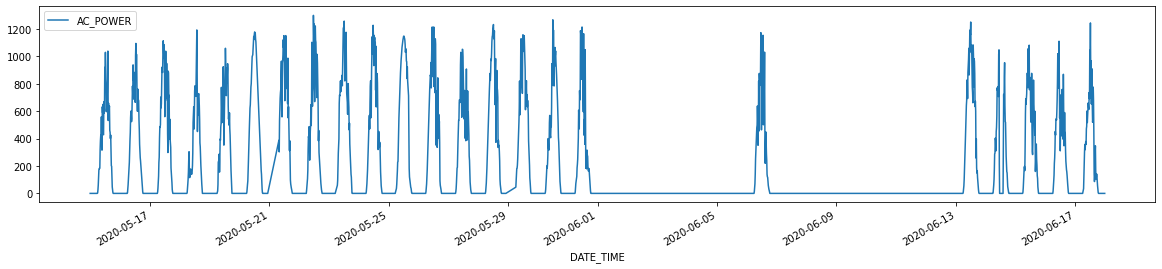

In [12]:
single_inverter_data.plot(x="DATE_TIME", y="AC_POWER", figsize=(20,4));

We immediately see a number of features in the data:

* **The power output seems to be periodic.** This makes sense, as the power output of a solar array is laregly dependent on the irradiation from the sun, which cycles with a period of one day.
* **There is missing data.** There are two large chunks of data generator missing in the timespan June 1st-6th and June 7th-13th. 
* **There is some noise in the data.** The power output changes a lot during the course of a single day. This can be caused by factors such as passing cloud coverage. While this is not possible to verify, it would be expected that the variance of this noise increases when there is partial cloud coverage passing over the array, and decreases on cloud-free days.

The periodicity of the data is also apparent in other parameters. We take a look at some other parameters from inverter ```1BY6WEcLGh8j5v7```:

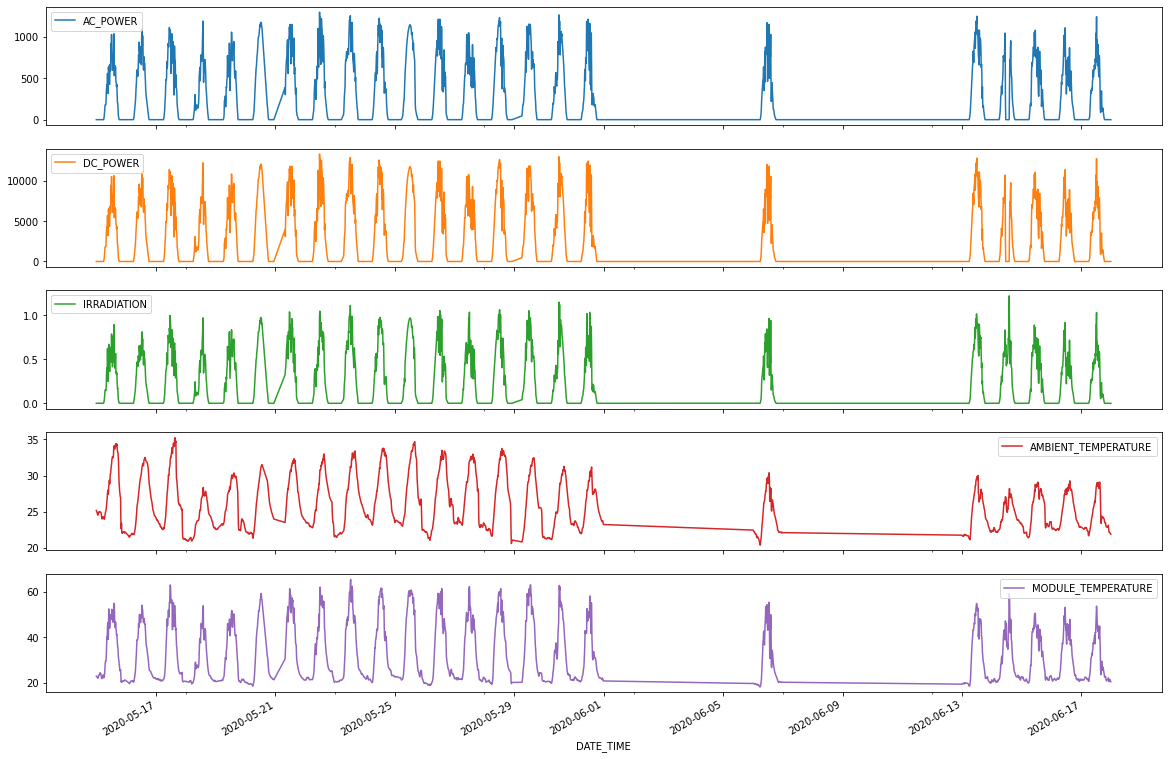

In [13]:
single_inverter_data.plot(x="DATE_TIME", y=["AC_POWER", "DC_POWER", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"], subplots=True, figsize=(20,14));

We also take a look at the daily yield of ```1BY6WEcLGh8j5v7```, which shows how the power production is accumulated throughout the day, and is reset at midnight:

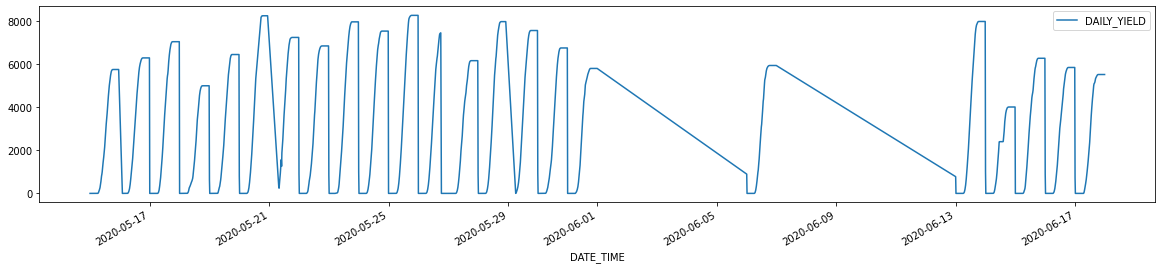

In [14]:
single_inverter_data.plot(x="DATE_TIME", y="DAILY_YIELD", figsize=(20,4));

Finally we take a look at the total yield of ```1BY6WEcLGh8j5v7```, which shows the total energy the inverter has produced increasing monotonously in time:

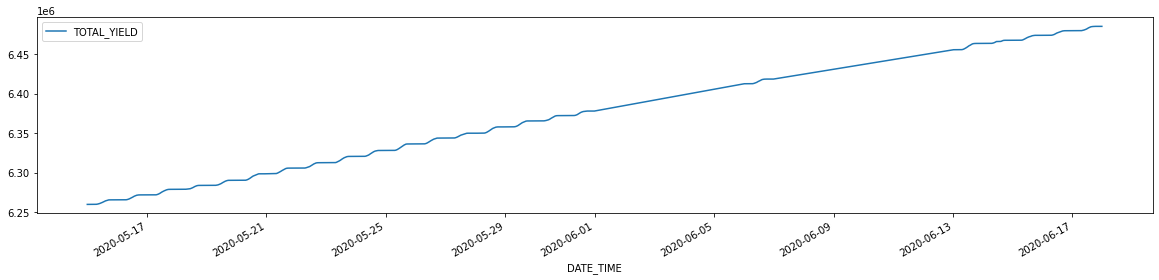

In [15]:
single_inverter_data.plot(x="DATE_TIME", y="TOTAL_YIELD", figsize=(20,4));

\
## Feature Engineering

As so much of the data is largely dependent on the time of the day, it makes sense to engineer a feature in the data to represent the time of day. To make this work with regression methods we define a new collumn in our data named ```MINUTES_PAST_MIDNIGHT``` which embodies the time of day in an integer format

In [16]:
alpha_data["MINUTES_PAST_MIDNIGHT"] = alpha_data.apply(lambda x: int((x["DATE_TIME"] - base_time).seconds/60), axis=1)

We will also engineer another feature which we will name ```EFFICIENCY``` which is calculated by dividing ```DC_POWER``` by ```IRRADIANCE``` , setting values where ```IRRADIANCE == 0``` to zero

In [17]:
alpha_data["EFFICIENCY"] = alpha_data.apply( lambda x: x["DC_POWER"] / x["IRRADIATION"] if x["IRRADIATION"] > 0 else 0, axis=1)

We can see the strong correlation in the data by using a scatter matrix on selected columns from ```1BY6WEcLGh8j5v7```:

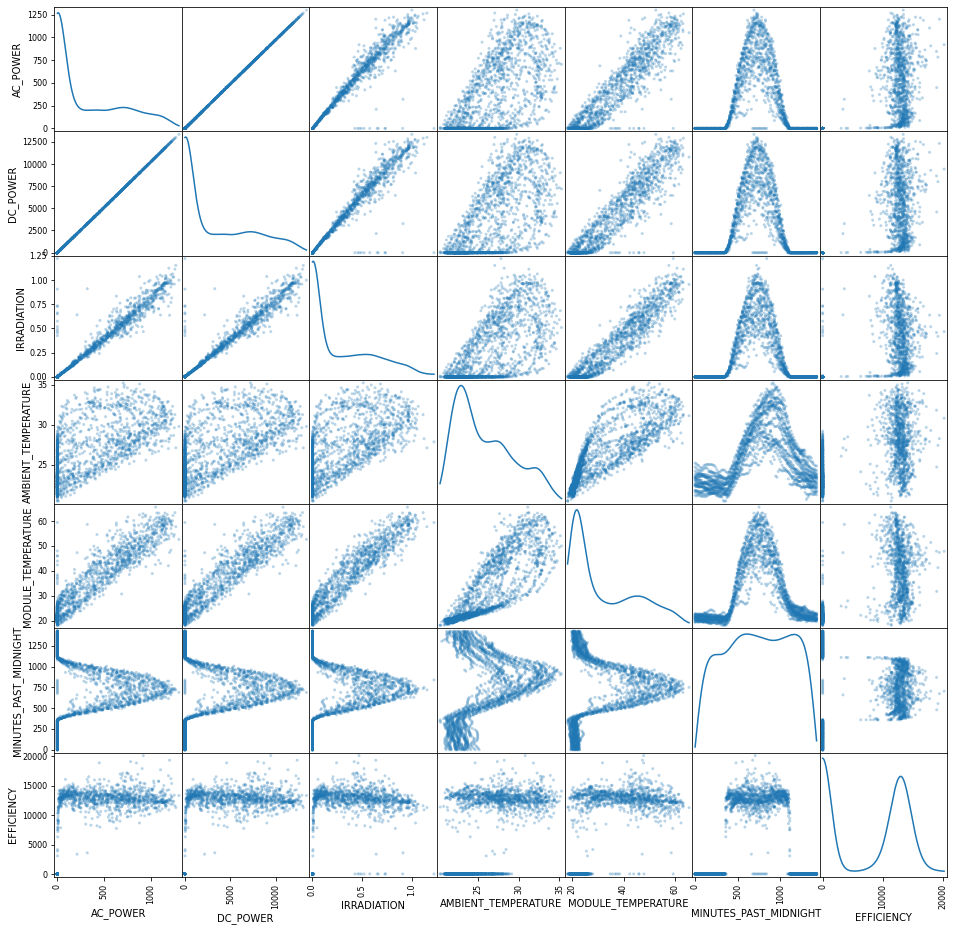

In [18]:
scatter_fields = ["AC_POWER", "DC_POWER", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "MINUTES_PAST_MIDNIGHT", "EFFICIENCY"]
single_inverter_data = alpha_data[alpha_data["SOURCE_KEY_INVERTER"]=="1BY6WEcLGh8j5v7"]
scatter_matrix(single_inverter_data[scatter_fields], alpha=0.3, figsize=(16, 16), diagonal='kde');

A couple of things are worth noting here:

* **There is some kind of linear correlation between most of the parameters.** For all parameter except ```MINUTES_PAST_MIDNIGHT``` AND ```EFFICIENCY```  There is some linear correlation. 
* **There is some kind of relation between ```MINUTES_PAST_MIDNIGHT``` and the other parameters.** This correlation, however, is not linear and follows a bell-curve. 
* **There is an extremely strong corelation between ```DC_POWER``` and ```AC_POWER```.** This correlation is so strong that it can *almost* be interpreted as a completely linear relation.
* **There is little correlation between ```EFFICIENCY``` and the features  ```DC_POWER```,```AC_POWER``` and ```IRRADIATION```.** This could indicate that the solar panels used in the powerplant are of high quality, as they are as efficient in low lighting as they are when the irradiation is at its highest 


\
## Principal Component Analysis

We now perform Principal Component Analysis (PCA) to the dataset to investigate the underlying dimensionality of the generation and sensor data from powerplant **Alpha**.
Some features are selected for the PCA:

In [19]:
alpha_pca_features = ["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "MINUTES_PAST_MIDNIGHT","EFFICIENCY"] 

We extract the desired features from the dataset and scale all the variables to unit variance. This is necessary as the different features have different units and scaling. 

In [20]:
alpha_pca_data = alpha_data.loc[:, alpha_pca_features].values
alpha_pca_data = StandardScaler().fit_transform(alpha_pca_data)

The PCA is performed with a maximum of 6 components

In [21]:
alpha_pca = PCA(n_components=6)
alpha_pca.fit(alpha_pca_data)
alpha_pca.components_

array([[ 4.23931353e-01,  4.23998521e-01,  1.09992313e-01,
        -3.28600737e-03,  3.71344843e-01,  4.32162476e-01,
         4.21568079e-01,  6.77214829e-02,  3.48469673e-01],
       [-1.30295830e-01, -1.30328688e-01,  6.70206762e-01,
        -3.04502184e-04,  2.20741152e-01, -3.06630060e-02,
        -1.31802308e-01,  6.67815656e-01, -6.19980574e-02],
       [ 1.33844363e-02,  1.33770348e-02,  9.52466286e-03,
         9.98501076e-01, -4.12453177e-02, -1.03335233e-02,
         3.47680879e-03,  1.21955653e-02,  2.40419795e-02],
       [-2.22197098e-01, -2.20713944e-01,  4.18851869e-03,
        -7.57025991e-03,  1.58369241e-01, -1.24862952e-01,
        -2.73803886e-01, -1.21208846e-01,  8.78354841e-01],
       [-1.73432108e-01, -1.73477075e-01,  1.51732185e-01,
         4.86509641e-02,  7.20101412e-01,  1.49747979e-01,
        -1.40291794e-01, -5.07570917e-01, -3.10091780e-01],
       [-1.14298896e-01, -1.13459258e-01, -7.17060759e-01,
         2.29172934e-02,  4.00066973e-01,  1.092726

Lets have a look at the explained variance ratio for the different components:

[0.57606127 0.7892047  0.90055366 0.9485228  0.98185092 0.99667261]


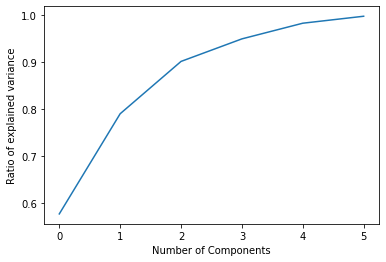

In [22]:
plt.plot(np.cumsum(alpha_pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Ratio of explained variance");
print(np.cumsum(alpha_pca.explained_variance_ratio_))

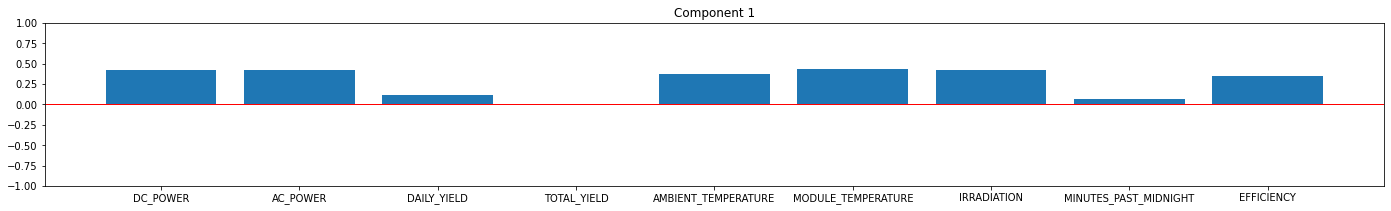

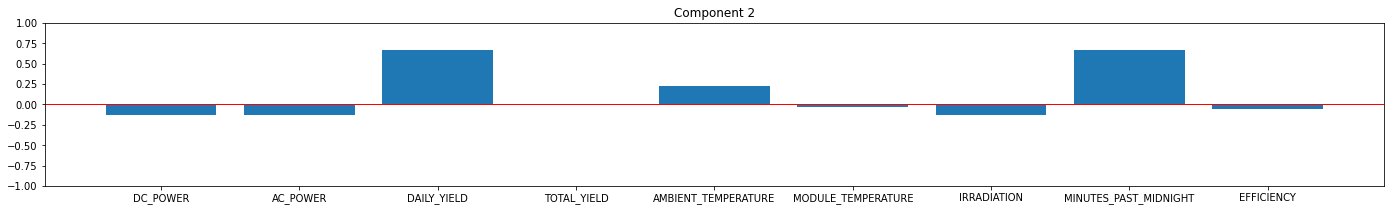

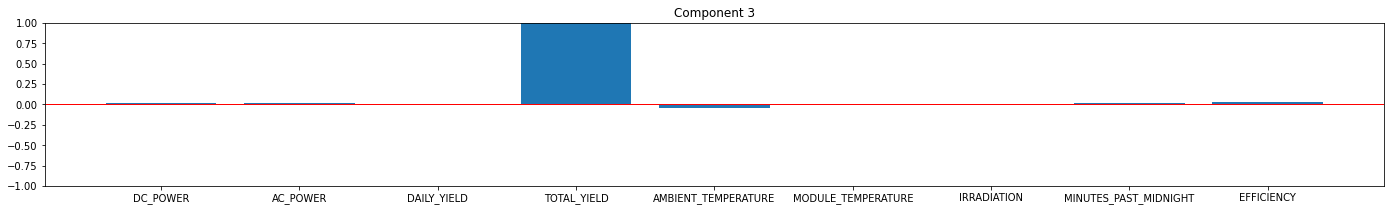

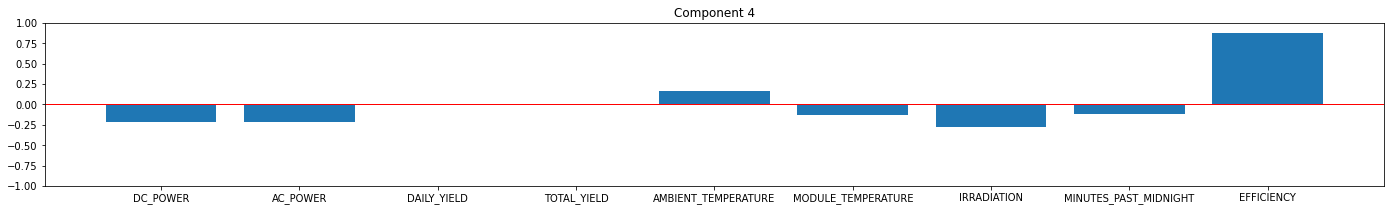

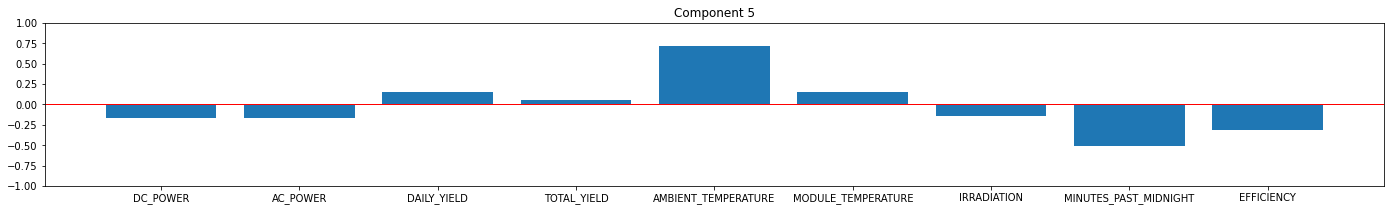

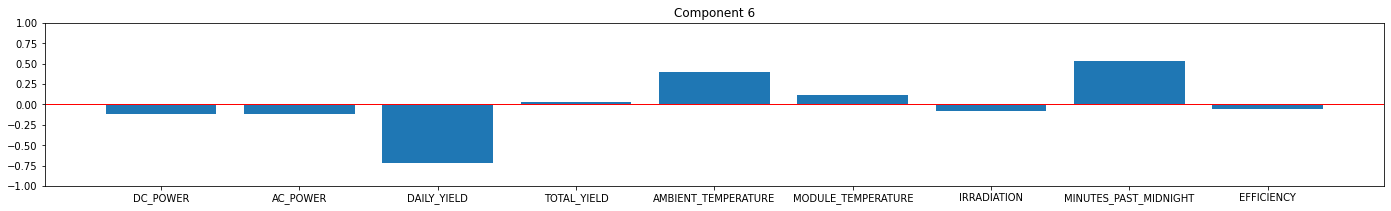

In [23]:

for n, c in enumerate(alpha_pca.components_, start=1):
    plt.subplots(figsize=(24,3))
    plt.ylim((-1,1))
    plt.title(f"Component {n}")
    plt.axhline(linewidth=1, color='r')
    plt.bar(alpha_pca_features, c)

\
## Partial Least Squares Regression

The next step is to see if it is possible to use the sensor data to predict the ```DC_POWER``` output of plant **Alpha**. This is advantageous for a number of reasons:

* Predicting the power output of the solar array can be valuable information for the controllers of the power grid, who can get an estimate of how much power the array can deliver to the network. 
* A good prediction can help us discover under-performing or damaged equipment, as they will likely deviate from the model.

We choose to use Partial Least Squares Regression (PLSR) to create a model for our data. First we split our dataset into training and validation data. We separate all the data from May 17th into a separate test data set. The goal is to see whether we can accurately predict the ```DC_POWER``` output of plant **Alpha** on  May 17th, based only on the sensor data from that day.

In [24]:
alpha_pls_training_data = alpha_data[(alpha_data["DATE_TIME"] < '2020-6-17')]
alpha_pls_test_data = alpha_data[(alpha_data["DATE_TIME"] >= '2020-6-17')]

We then pick what features we want to predict ```alpha_pls_ys``` and what data we want to use to make the predictions ```alpha_pls_xs```. In this case, we want to take the sensor data, along with the engineered feature  ```MINUTES_PAST_MIDNIGHT```  and accurately predict ```DC_POWER```. Thus we set it up like this:

In [25]:
alpha_pls_xs = ["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "MINUTES_PAST_MIDNIGHT"]
alpha_pls_ys = ["DC_POWER"]

alpha_pls_training_x = alpha_pls_training_data[alpha_pls_xs]
alpha_pls_training_y = alpha_pls_training_data[alpha_pls_ys]

alpha_pls_test_x = alpha_pls_test_data[alpha_pls_xs]
alpha_pls_test_y = alpha_pls_test_data[alpha_pls_ys]

As a first test, we perform PLSR on our newly separated training data with all 4 components. This is equivalent to performing MLR (Multiple Linear Regression)

In [26]:
alpha_pls = PLSRegression(n_components=4)
alpha_pls.fit(alpha_pls_training_x, alpha_pls_training_y)

PLSRegression(n_components=4)

As a first measure of performance, we perform k-fold cross-validation, in this case with ```k = 10``` and compute the $r²$ score and mean square error (MSE) after the cross-validation 

In [27]:
y_cv = cross_val_predict(alpha_pls, alpha_pls_training_x, alpha_pls_training_y, cv=10)

r2_score(alpha_pls_training_y, y_cv)

0.9824907363128014

In [28]:
mean_squared_error(alpha_pls_training_y, y_cv)

294760.89656294824

We see that for the training set, the quality of the prediction reaches an impressive $r²$. This, however, is not a good metric for the performance of our model, as we may have massively overfit the model. To see if the model is acutally accurate, we compute the $r²$ for the test data from May 17th:  

In [29]:
alpha_pls_predicted_y = alpha_pls.predict(alpha_pls_test_x)
r2_score(alpha_pls_test_y, alpha_pls_predicted_y)

0.987766563015282

By the score, we see that our MLR-model works well on unseen data too! to get an intutive understanding of how our model performs, 
we plot the actual power produced on May 17th ```DC_POWER``` against the predicted power production ```PREDICTED_DC``` for May 17th

<AxesSubplot:xlabel='DATE_TIME'>

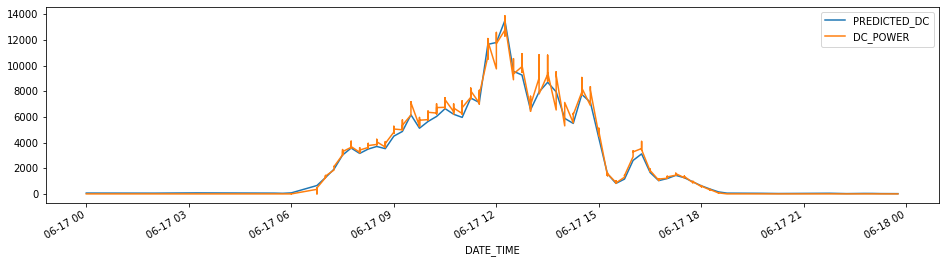

In [30]:
alpha_pls_test_data_plot = alpha_pls_test_data.assign(PREDICTED_DC = alpha_pls_predicted_y)
alpha_pls_test_data_plot.plot(x="DATE_TIME", y=["PREDICTED_DC", "DC_POWER"], figsize=(16,4))

In [31]:
for n in range(1, len(alpha_pls_xs)+1):
    alpha_pls = PLSRegression(n_components=n)
    alpha_pls.fit(alpha_pls_training_x, alpha_pls_training_y)
    y_cv = cross_val_predict(alpha_pls, alpha_pls_training_x, alpha_pls_training_y, cv=10)
    cv_score = r2_score(alpha_pls_training_y, y_cv)
    alpha_pls_predicted_y = alpha_pls.predict(alpha_pls_test_x)
    pred_score = r2_score(alpha_pls_test_y, alpha_pls_predicted_y)
    print(f"n={n}: cross validation r2 = {cv_score}, test score = {pred_score}")
    

n=1: cross validation r2 = 0.8990466596496856, test score = 0.9207158800915498
n=2: cross validation r2 = 0.9494281444305921, test score = 0.9317195101037301
n=3: cross validation r2 = 0.9794049574741372, test score = 0.9832327032379884
n=4: cross validation r2 = 0.9824907363128014, test score = 0.987766563015282


\
## Outlier detection and Predictive Maintenance

Our newly developed model could prove useful when moving to the field of predictive maintenance. The powerplant consists of several inverters, which are in need of regular maintenance. Sending technicians to repair or service these inverters is expensive, and should only be done when necessary to keep costs down. Thus we want to avoid accidentaly flagging an inverter as malfunctioning when it is, in reality, doing fine.

So what does it look like when an inverter fails? The following plot shows the ```DC_POWER``` output of the individual inverters of the powerplant on April 6th throughout the day:

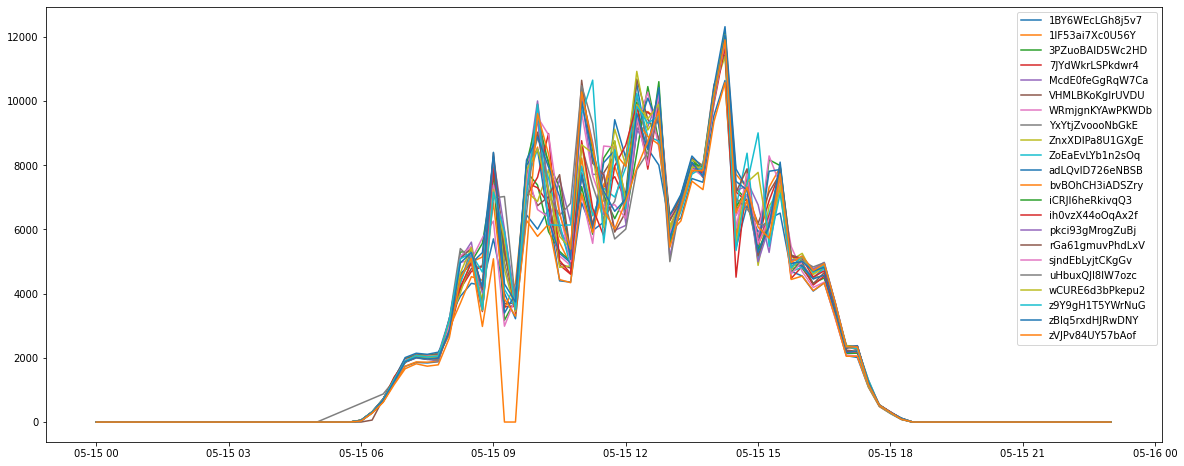

In [32]:
fig, ax = plt.subplots(figsize=(20,8))

for key, grp in alpha_data[(alpha_data["DATE_TIME"] < '2020-5-16')].groupby("SOURCE_KEY_INVERTER"):
    ax.plot(grp['DATE_TIME'], grp['DC_POWER'], label=key)

ax.legend()
plt.show()

At 09:30 we can see that a single inverter's power output ```DC_POWER``` falls to zero despite the other inverters performing as expected. This is a clear sign of possible inverter failure. 

**So, how can we accurately predict which inverters are failing?**

First, we need a metric of performance. How do we measure if an inverter is performing suboptimally and needs service or repair?
An intuitive first thought would be to use the DC-power as the metric. If an inverter produces less power, then it is probably malfunctioning. While idea is not entierly wrong, it does have some core flaws:

* The powerplant does not have any way of measuring cloud coverage. An overcast sky might cause all inverters to produce less power, and as such indicate that all inverters are malfunctioning. 
* The irradiance of the sun might also change with the seasons, giving a lower DC-power output in the winter months (assuming the plant is in the northern hemisphere)
* Another trivial problem is that every inverter would be flagged as malfunctioning at night, as they are not producing any power.

Another metric could be to look at the ```EFFICIENCY``` feature which was previousy engineered.


Let's take a closer look at the plot showing the correlation between ```IRRADIATION``` and ```DC_POWER```, which constitute the two features needed to calculate efficiency:

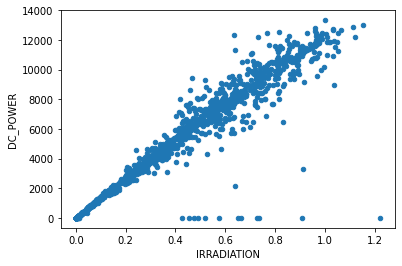

In [33]:
single_inverter_data.plot.scatter(x="IRRADIATION", y="DC_POWER");

There are som outliers in the samples which are located in the lower right half of the plot. These samples indicate a low ```DC_POWER``` compared to  ```IRRADIATION```, which in turn shows a low ```EFFICIENCY```. These points might indicate a faulty inverter.

Picking out inverters with low ```EFFICIENCY``` might work well as a way of selecting which inverters should be serviced by a technician, however, this method has some flaws

* first, we see that the variance of ```EFFICIENCY``` increases as the ```IRRADIATION``` gets larger. This will make it more likely to accidentaly mark inverters as malfunctioning, when the irradiation is high. 
* Another thing that is worth considering is that the efficiency has a small, but not insignificant, inverse correlation with the irradiation. As the irradiation increases, the efficiency of the inverters decrease slightly. One possible cause for this phenomenon might be that the solar panels perform worse as they get warmer. This will make it more likely that an inverter is flagged as malfunctioning on typically warm days with high irradiation.


Finally we choose the approach of using our previously developed regression model to ascertain if an inverter is failing. We propose the following method:

When given a set of measurements from the plant, run the ```AMBIENT_TEMPERATURE```,  ```MODULE_TEMPERATURE```, ```IRRADIATION```, and ```MINUTES_PAST_MIDNIGHT``` through the model, and compute an expected power output ```PREDICTED_DC_POWER``` if the predicted power is lower thath the produced power by a significant amount, the inverter should be flagged as malfunctioning.

In [41]:
alpha_data["PREDICTED_DC_POWER"] = alpha_pls.predict(alpha_data[alpha_pls_xs])

We engineer a new feature in the data named ```POWER_ERROR``` which is computed by subtracting the actual DC power produced by the inverter ```DC_POWER``` by the DC power that our model predicted that the inverter would produce, ```PREDICTED_DC_POWER```

We plot the ```POWER_ERROR``` for each row in the dataset and display it as a histogram. *Note that the y-axis is plotted on a log scale, as the vast majority of the samples are centered around 0*

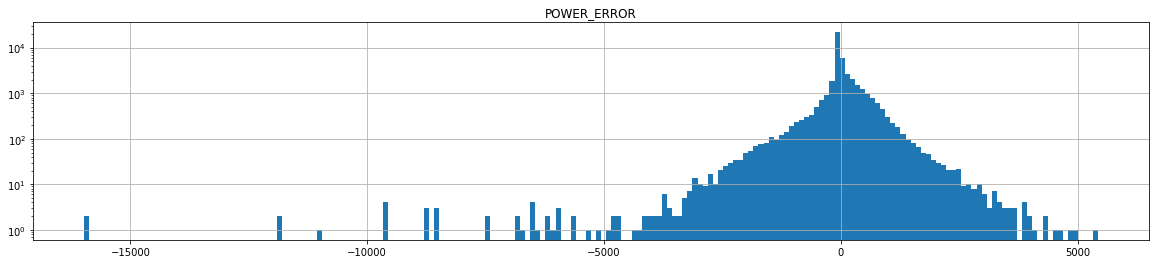

In [44]:
alpha_data["POWER_ERROR"] = alpha_data["DC_POWER"] - alpha_data["PREDICTED_DC_POWER"]
alpha_data.hist(column="POWER_ERROR", bins = 200, figsize=(20,4), log=True);

As expected, the power error is centered around 0. There are some outliers in the positive direction where the solar panels are over-performing, but the vast majority of the outliers are in the negative direction where the solar panels are under-performing. In order to set a threshold for which a solar panel should be flagged as malfunctioning, we compute the standard deviation ($\sigma$) of ```POWER_ERROR``` over all samples

In [45]:
power_error_stdev = alpha_data["POWER_ERROR"].std()
power_error_stdev

534.2831637773002

With this standard deviation we see that the vast majority of the samples fall within $5 \sigma$, with only the noticable outliers falling outside $5 \sigma$. Thus we engineer a boolean feature in the data, named ```SUBOPTIMAL_PERFORMANCE``` which is defined by

In [46]:
alpha_data["SUBOPTIMAL_PERFORMANCE"] = alpha_data["POWER_ERROR"] < -5*power_error_stdev

The original dataset from powerplant **Alpha** is divided into two sets, based on this rule

In [47]:
suboptimal_data = alpha_data.query("SUBOPTIMAL_PERFORMANCE")
non_suboptimal_data = alpha_data.query("not SUBOPTIMAL_PERFORMANCE")

The two sets are plotted in a scatter plot to show which datapoints were flagged as suboptimal

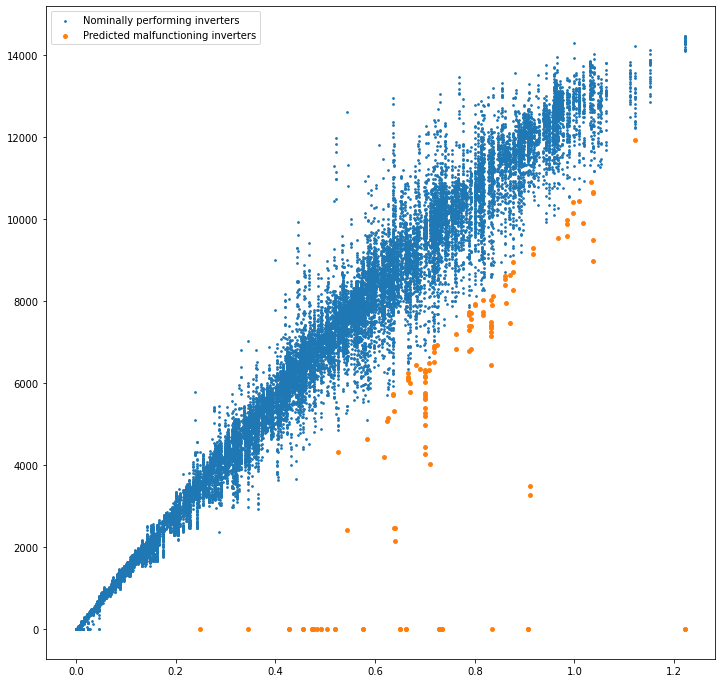

In [50]:
plt.subplots(figsize=(12,12))
plt.scatter(x=non_suboptimal_data["IRRADIATION"], y=non_suboptimal_data["DC_POWER"], label="Nominally performing inverters", s=3)
plt.scatter(x=suboptimal_data["IRRADIATION"], y=suboptimal_data["DC_POWER"], label="Predicted malfunctioning inverters", s=15)
plt.legend()

As expected, the data points to the lower right part of the plot are flagged as suboptimal. These are the datapoints where the efficiency of an inverter is stypically low. By plotting with different axes, it is clear that the inverters with low efficiency are flagged most often:

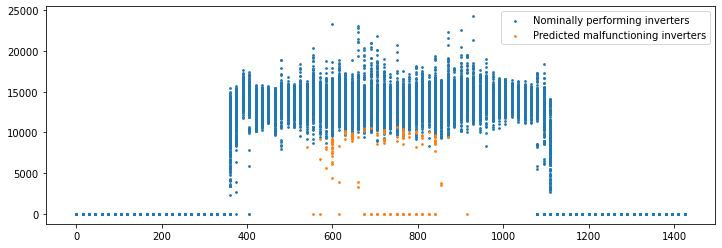

In [51]:
plt.subplots(figsize=(12,4))
plt.scatter(x=non_suboptimal_data["MINUTES_PAST_MIDNIGHT"], y=non_suboptimal_data["EFFICIENCY"], label="Nominally performing inverters", s=3)
plt.scatter(x=suboptimal_data["MINUTES_PAST_MIDNIGHT"], y=suboptimal_data["EFFICIENCY"], label="Predicted malfunctioning inverters", s=3)
plt.legend()

We close our scope in on a single day. Let's look again at the ```DC_POWER``` production throughout the day April 16th where the datapoints which are classified as malfunctioning are marked:

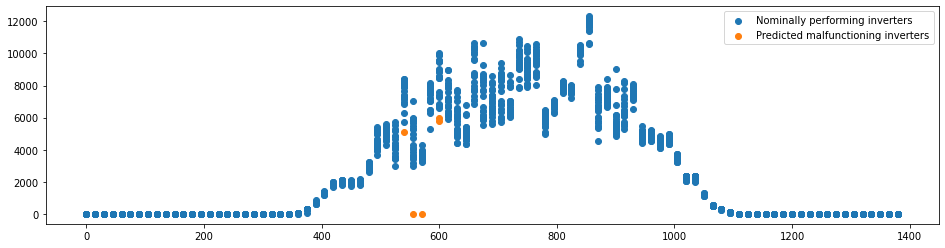

In [54]:
suboptimal_data_single_day = suboptimal_data[suboptimal_data["DATE_TIME"] < '2020-5-16']
non_suboptimal_data_single_day = non_suboptimal_data[non_suboptimal_data["DATE_TIME"] < '2020-5-16']

plt.subplots(figsize=(16,4))
plt.scatter(x=non_suboptimal_data_single_day["MINUTES_PAST_MIDNIGHT"], y=non_suboptimal_data_single_day["DC_POWER"], label="Nominally performing inverters")
plt.scatter(x=suboptimal_data_single_day["MINUTES_PAST_MIDNIGHT"], y=suboptimal_data_single_day["DC_POWER"], label="Predicted malfunctioning inverters")
plt.legend();


Interestingly enough, the two zero valus from around 09:30 are flagged as suboptimal, as well as some datapoints immediately before and after the failure. 

There is reason to argue that this very basic classifier is working, however, this is difficult to verify as we have no ground truth on whether an inverter is failing or not. 

This very basic classifier has a core issue: It is way more likely to predict a suboptimally performing inverter in the middle of the day vs in the mornings. We make the assumtion that the probability of an inverter is failing given the time of day should be evenly distributed throughout the working day, with no failures happening at night. However when we plot a histogram of how the failures distribute throughout the day, we see that all the failures are centered around the middle of the day, with no failures predicted in the morning hours or the afternoon:

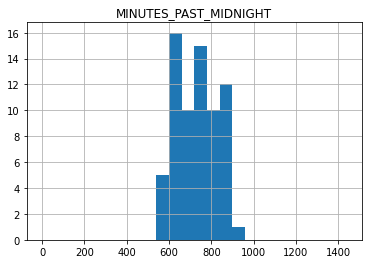

In [40]:
suboptimal_data.hist(column="MINUTES_PAST_MIDNIGHT", range=(0, 1440), bins=24);

It is supected that this is due to the model not being able to capture the non-constant variance in the ```DC_POWER``` data. As irradiance increases, the variance of the ```DC_POWER``` increases which may contribute to the number of predicted malfunctions being larger in the middle of the day. An improved model would likely have "higher" requirements for a datapoint to be flagged as malfunctioning in the middle of the day when the variance is at its highest.